<a href="https://colab.research.google.com/github/jchen9314/pyspark-learning/blob/main/pyspark_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pandas vs. Pyspark SQL



|Function|Pandas|Pyspark SQL|
|--|--|--|
|Import|import pandas as pd|import pyspark<br/> from pyspark.sql import SparkSession <br/> spark = SparkSession.builder.getOrCreate()|
|Read csv|df = pd.read_csv(filepath, header=)|df = spark.read.csv(filepath, header=)|
|View df|df.head(n)|df.take(n): return list of Row objects <br/> df.collect(): get all of the data from DataFrame, be careful to use this for large dataset, can easily crash the driver node <br/> df.show(): print out dataframe in a nice format <br/> df.limit(n): return a new DataFrame<br/>df.head(n): return list, similar to take function|
|Schema|df.types|df.printSchema() <br/> df.types|
|Access a column|df.column1 <br/> df['column1']|df.column1 <br/> df['column1'] <br/> df.select(col('column1'))|
|Select multiple columns|df[['column1', 'column2']]| df.select('column1', 'column2').show(3)|
|Add a column|df['NewColumn'] = 2\*df['Column']|df.withColumn('DoubleColumn',2\*df['Acolumn'])|
|Rename a column|df.rename(columns={'ExisingColumnName':'NewColumnName'})|df.withColumnRenamed(ExistingColumnName, NewColumnName)|
|Remove columns|df.drop('ColumnName', axis=1, inplace=True)|df.drop('ColumnName') <br/> df.drop('ColumnName1', 'ColumnName2', 'ColumnName3'): doesn't need to put column names in a list|
|Group by|df.groupby('Column')|df.groupBy('Column')|
|Filter rows|df[df.column > 1]| df.filter(col('column') > 1)|
|Get unique rows|df.column.unique()|df.select(column).distinct().show()|
|Sort rows|df.column.sort_values(by=)|df.orderBy('column')|
|Append rows\/dfs|pd.concat([df, df1], axis=0)|df.union(df1)|
|Length of df|len(df) <br/> df.shape[0]|df.count()|
|Get count of unique values in a column|df['column'].value_counts()|df.groupBy('column').count().show()|
|Built-in function (eg. mean)|df.column1.mean()|from pyspark.sql.functions import mean <br/> df.select(mean(df.column1)).show()|

## Download and install Spark

In [1]:
!ls

sample_data


In [2]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bi

## Setup environment

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [4]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD

--2021-05-15 20:56:04--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [     <=>            ]   1.61G  3.24MB/s    in 8m 32s  

2021-05-15 21:04:36 (3.22 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1728000926]



In [5]:
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv

In [6]:
!ls

reported-crimes.csv  spark-2.3.1-bin-hadoop2.7
sample_data	     spark-2.3.1-bin-hadoop2.7.tgz


In [7]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

## Schema

In [8]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [9]:
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [10]:
# declare schema

from pyspark.sql.types import StructType, StructField, StringType, TimestampType, BooleanType, IntegerType, DoubleType

In [11]:
labels = [('ID', StringType()),
 ('Case Number', StringType()),
 ('Date', TimestampType()),
 ('Block', StringType()),
 ('IUCR', StringType()),
 ('Primary Type', StringType()),
 ('Description', StringType()),
 ('Location Description', StringType()),
 ('Arrest', StringType()),
 ('Domestic', BooleanType()),
 ('Beat', StringType()),
 ('District', StringType()),
 ('Ward', StringType()),
 ('Community Area', StringType()),
 ('FBI Code', StringType()),
 ('X Coordinate', StringType()),
 ('Y Coordinate', StringType()),
 ('Year', IntegerType()),
 ('Updated On', StringType()),
 ('Latitude', DoubleType()),
 ('Longitude', StringType()),
 ('Location', StringType())
 ]

In [12]:
schema = StructType([StructField(x[0], x[1], True) for x in labels])

## Working with columns

In [13]:
rc.select('IUCR').show(5)
# rc.select(col('IUCR')).show(5)

+----+
|IUCR|
+----+
|0486|
|0870|
|0810|
|2023|
|0560|
+----+
only showing top 5 rows



In [14]:
rc.select('Case Number', 'Date', 'Arrest').show()

+-----------+-------------------+------+
|Case Number|               Date|Arrest|
+-----------+-------------------+------+
|   HY411648|2015-09-05 13:30:00| false|
|   HY411615|2015-09-04 11:30:00| false|
|   JC213529|2018-09-01 00:01:00| false|
|   HY411595|2015-09-05 12:45:00|  true|
|   HY411610|2015-09-05 13:00:00| false|
|   HY411435|2015-09-05 10:55:00| false|
|   HY411629|2015-09-04 18:00:00| false|
|   HY411605|2015-09-05 13:00:00|  true|
|   HY411654|2015-09-05 11:30:00| false|
|   JC212333|2016-05-01 00:25:00| false|
|   HY411662|2015-09-05 14:00:00| false|
|   HY411626|2015-09-05 11:00:00| false|
|   HY411632|2015-09-05 03:00:00| false|
|   HY411566|2015-09-05 12:50:00| false|
|   HY411601|2015-09-03 13:00:00| false|
|   HY411489|2015-09-05 11:45:00| false|
|   HY411656|2015-09-05 13:30:00| false|
|   HY410094|2015-07-08 00:00:00| false|
|   HY411388|2015-09-05 09:55:00|  true|
|   HY411568|2015-09-05 12:35:00| false|
+-----------+-------------------+------+
only showing top

In [15]:
# add a column named One with entries all 1
from pyspark.sql.functions import lit

rc.withColumn('One', lit(1)).show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+---+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|One|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+---+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|

In [16]:
# drop column
rc = rc.drop('IUCR')
rc.show(5)

+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            6

## Working with rows

In [17]:
# add new rows
one_day = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2018-11-12')).drop('IUCR')

one_day.count()

3

In [18]:
rc.union(one_day).orderBy('Date', ascending=False).show(5)

+--------+-----------+-------------------+--------------------+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11516594|   JB528186|2018-11-12 00:00:00| 049XX S PRAIRIE AVE|      OTHER OFFENSE|HARASSMENT BY ELE...|               OTHER| false|   false|0224

In [19]:
rc.groupBy('Primary Type').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|        Primary Type|  count|
+--------------------+-------+
|               THEFT|1418449|
|             BATTERY|1232245|
|     CRIMINAL DAMAGE| 771501|
|           NARCOTICS| 711748|
|       OTHER OFFENSE| 418868|
|             ASSAULT| 418512|
|            BURGLARY| 388037|
| MOTOR VEHICLE THEFT| 314131|
|  DECEPTIVE PRACTICE| 266347|
|             ROBBERY| 255598|
|   CRIMINAL TRESPASS| 193371|
|   WEAPONS VIOLATION|  70662|
|        PROSTITUTION|  68329|
|PUBLIC PEACE VIOL...|  47785|
|OFFENSE INVOLVING...|  46094|
| CRIM SEXUAL ASSAULT|  26733|
|         SEX OFFENSE|  25409|
|INTERFERENCE WITH...|  15140|
|            GAMBLING|  14422|
|LIQUOR LAW VIOLATION|  14068|
+--------------------+-------+
only showing top 20 rows



### what percentage of reported crimes resulted in an arrest

In [20]:
# check distinct values in Arrest column
rc.select('Arrest').distinct().show()

+------+
|Arrest|
+------+
| false|
|  true|
+------+



In [21]:
rc.filter(col('Arrest') == 'true').count() / rc.count()

0.2775451683434286

### waht are the top 3 locations for reported crimes

In [22]:
rc.groupBy('Location Description').count().orderBy('count', ascending=False).show(3)

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1770581|
|           RESIDENCE|1145281|
|           APARTMENT| 698509|
+--------------------+-------+
only showing top 3 rows



## Built-in functions

In [23]:
from pyspark.sql import functions

In [24]:
# list all built-in functions in functions module
print(dir(functions))

['AutoBatchedSerializer', 'Column', 'DataFrame', 'DataType', 'PandasUDFType', 'PickleSerializer', 'PythonEvalType', 'SparkContext', 'StringType', 'UserDefinedFunction', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_binary_mathfunctions', '_collect_list_doc', '_collect_set_doc', '_create_binary_mathfunction', '_create_function', '_create_udf', '_create_window_function', '_functions', '_functions_1_4', '_functions_1_6', '_functions_2_1', '_functions_deprecated', '_lit_doc', '_message', '_string_functions', '_test', '_to_java_column', '_to_seq', '_window_functions', '_wrap_deprecated_function', 'abs', 'acos', 'add_months', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_contains', 'asc', 'ascii', 'asin', 'atan', 'atan2', 'avg', 'base64', 'bin', 'bitwiseNOT', 'blacklist', 'broadcast', 'bround', 'cbrt', 'ceil', 'coalesce', 'col', 'collect_list', 'collect_set', 'column', 'concat', 'concat_ws', 'conv', 'c

In [25]:
help(functions.substring)

Help on function substring in module pyspark.sql.functions:

substring(str, pos, len)
    Substring starts at `pos` and is of length `len` when str is String type or
    returns the slice of byte array that starts at `pos` in byte and is of length `len`
    when str is Binary type.
    
    .. note:: The position is not zero based, but 1 based index.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(substring(df.s, 1, 2).alias('s')).collect()
    [Row(s='ab')]
    
    .. versionadded:: 1.5



In [26]:
from pyspark.sql.functions import lower, upper, substring
rc.select(lower(col('Primary Type')), upper(col('Primary Type')), substring(col('Primary Type'), 1, 4)).show(5)

+-------------------+-------------------+-----------------------------+
|lower(Primary Type)|upper(Primary Type)|substring(Primary Type, 1, 4)|
+-------------------+-------------------+-----------------------------+
|            battery|            BATTERY|                         BATT|
|              theft|              THEFT|                         THEF|
|              theft|              THEFT|                         THEF|
|          narcotics|          NARCOTICS|                         NARC|
|            assault|            ASSAULT|                         ASSA|
+-------------------+-------------------+-----------------------------+
only showing top 5 rows



In [27]:
from pyspark.sql.functions import min, max

rc.select(min(col('Date')), max(col('Date'))).show(1)

+-------------------+-------------------+
|          min(Date)|          max(Date)|
+-------------------+-------------------+
|2001-01-01 00:00:00|2018-11-10 23:55:00|
+-------------------+-------------------+



In [28]:
from pyspark.sql.functions import date_add, date_sub

rc.select(date_sub(min(col('Date')), 3), date_add(max(col('Date')), 3)).show(1)

+----------------------+----------------------+
|date_sub(min(Date), 3)|date_add(max(Date), 3)|
+----------------------+----------------------+
|            2000-12-29|            2018-11-13|
+----------------------+----------------------+



## Dates and timestamps

In [29]:
from pyspark.sql.functions import to_date, to_timestamp, lit

In [30]:
df = spark.createDataFrame([('2019-12-25 13:30:00', )], ['Christmas'])
df.show(1)

+-------------------+
|          Christmas|
+-------------------+
|2019-12-25 13:30:00|
+-------------------+



In [31]:
df.select(to_date(col('Christmas'), 'yyyy-MM-dd HH:mm:ss'), to_timestamp(col('Christmas'), 'yyyy-MM-dd HH:mm:ss')).show(1)

+-------------------------------------------+------------------------------------------------+
|to_date(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|to_timestamp(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|
+-------------------------------------------+------------------------------------------------+
|                                 2019-12-25|                             2019-12-25 13:30:00|
+-------------------------------------------+------------------------------------------------+



In [32]:
df = spark.createDataFrame([('25/Dec/2019 13:30:00', )], ['Christmas'])
df.show(1)

+--------------------+
|           Christmas|
+--------------------+
|25/Dec/2019 13:30:00|
+--------------------+



In [33]:
df.select(to_date(col('Christmas'), 'dd/MMM/yyyy HH:mm:ss'), to_timestamp(col('Christmas'), 'dd/MMM/yyyy HH:mm:ss')).show(1)

+--------------------------------------------+-------------------------------------------------+
|to_date(`Christmas`, 'dd/MMM/yyyy HH:mm:ss')|to_timestamp(`Christmas`, 'dd/MMM/yyyy HH:mm:ss')|
+--------------------------------------------+-------------------------------------------------+
|                                  2019-12-25|                              2019-12-25 13:30:00|
+--------------------------------------------+-------------------------------------------------+



In [34]:
df = spark.createDataFrame([('12/25/2019 01:30:00 PM', )], ['Christmas'])
df.show(1, truncate=False)

+----------------------+
|Christmas             |
+----------------------+
|12/25/2019 01:30:00 PM|
+----------------------+



In [35]:
df.select(to_date(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa'), to_timestamp(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa')).show(1)

+----------------------------------------------+---------------------------------------------------+
|to_date(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|to_timestamp(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|
+----------------------------------------------+---------------------------------------------------+
|                                    2019-12-25|                                2019-12-25 13:30:00|
+----------------------------------------------+---------------------------------------------------+



## Join

In [36]:
!wget -O police-station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD

--2021-05-15 21:15:07--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police-station.csv’

police-station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2021-05-15 21:15:07 (336 MB/s) - ‘police-station.csv’ saved [5699]



In [37]:
ps = spark.read.csv('police-station.csv', header=True)
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

In [38]:
rc.cache()
rc.count()

6754288

In [39]:
ps.select('DISTRICT').distinct().show(30)

+--------------------+
|            DISTRICT|
+--------------------+
|                   7|
|                  15|
|                  11|
|                   3|
|                   8|
|                  22|
|                  16|
|                   5|
|                  18|
|                  17|
|                   6|
|                  19|
|                  25|
|        Headquarters|
|                  24|
|                   9|
|                   1|
|                  20|
|                  10|
|                   4|
|                  12|
|                  14|
|                   2|
|",Chicago,IL,6060...|
+--------------------+



In [40]:
rc.select('District').distinct().show(30)

+--------+
|District|
+--------+
|     009|
|     012|
|     024|
|    null|
|     031|
|     015|
|     006|
|     019|
|     020|
|     011|
|     025|
|     005|
|     003|
|     016|
|     018|
|     008|
|     022|
|     001|
|     014|
|     010|
|     004|
|     017|
|     007|
|     021|
|     002|
+--------+



In [41]:
from pyspark.sql.functions import lpad

In [42]:
lpad?

In [43]:
ps.select(lpad(col('DISTRICT'), 3, '0')).show(10)

+--------------------+
|lpad(DISTRICT, 3, 0)|
+--------------------+
|                 Hea|
|                 018|
|                 019|
|                 020|
|                 022|
|                 024|
|                 025|
|                 001|
|                 002|
|                 003|
+--------------------+
only showing top 10 rows



In [44]:
ps = ps.withColumn('Format_district', lpad(col('DISTRICT'), 3, '0'))
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 117

In [45]:
rc.join(ps, rc.District == ps.Format_district, 'left_outer').show()

+--------+-----------+-------------------+--------------------+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|      ID|Case Number|               Date|               Block|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|DISTRICT| DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+-----

In [46]:
ps.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format_district']

In [47]:
rc.join(ps, rc.District == ps.Format_district, 'left_outer').drop(
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION').show()

+--------+-----------+-------------------+--------------------+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
|      ID|Case Number|               Date|               Block|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT| DISTRICT NAME|Format_district|
+--------+-----------+-------------------+--------------------+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|2015|02/10/2018 03:50:...|       9|       Deering|            009|


### what is the most frequently reported non-criminal activity

In [48]:
rc.select('Primary Type').distinct().orderBy('Primary Type').show(35, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [49]:
nc = rc.filter((col('Primary Type') == 'NON - CRIMINAL') | (col('Primary Type') == 'NON-CRIMINAL') | (col('Primary Type') == 'NON-CRIMINAL (SUBJECT SPECIFIED)'))
nc.show(50)

+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10233370|   HY421530|2015-09-13 10:45:00|  010XX S MENARD AVE|      NON - CRIMINAL|   FOID - REVOCATION|           RESIDENCE|  true|   false|

In [50]:
nc.groupBy('Description').count().orderBy('count', ascending=False).show(5, truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|FOUND PASSPORT                             |4    |
+-------------------------------------------+-----+
only showing top 5 rows



### which day of the week has the most number of reported crime

In [51]:
from pyspark.sql.functions import dayofweek
from pyspark.sql.functions import date_format

In [52]:
rc.select('Date', dayofweek('Date'), date_format('Date', 'E')).show(5)

+-------------------+---------------+--------------------+
|               Date|dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2015-09-05 13:30:00|              7|                 Sat|
|2015-09-04 11:30:00|              6|                 Fri|
|2018-09-01 00:01:00|              7|                 Sat|
|2015-09-05 12:45:00|              7|                 Sat|
|2015-09-05 13:00:00|              7|                 Sat|
+-------------------+---------------+--------------------+
only showing top 5 rows



In [53]:
rc.groupBy(date_format('Date', 'E')).count().orderBy('count', ascending=False).show(5)

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1017113|
|                 Wed| 974029|
|                 Tue| 968171|
|                 Sat| 965309|
|                 Thu| 964711|
+--------------------+-------+
only showing top 5 rows



In [54]:
rc.groupBy(date_format('Date', 'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=912088),
 Row(date_format(Date, E)='Mon', count=952867),
 Row(date_format(Date, E)='Thu', count=964711),
 Row(date_format(Date, E)='Sat', count=965309),
 Row(date_format(Date, E)='Wed', count=974029),
 Row(date_format(Date, E)='Fri', count=1017113),
 Row(date_format(Date, E)='Tue', count=968171)]

In [56]:
dow = [x[0] for x in rc.groupBy(date_format('Date', 'E')).count().collect()]
cnt = [x[1] for x in rc.groupBy(date_format('Date', 'E')).count().collect()]

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
cp = pd.DataFrame({'Day_of_week':dow, 'Count': cnt})
cp.head()

,Day_of_week,Count
0,Sun,912088
1,Mon,952867
2,Thu,964711
3,Sat,965309
4,Wed,974029


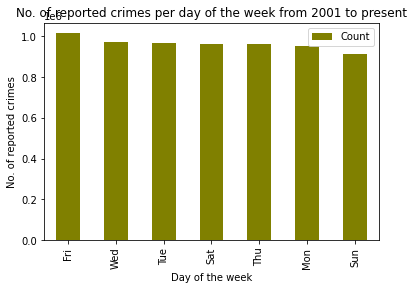

In [61]:
cp.sort_values('Count',ascending=False).plot(kind='bar', color='olive', x='Day_of_week', y='Count')
plt.xlabel('Day of the week')
plt.ylabel('No. of reported crimes')
plt.title('No. of reported crimes per day of the week from 2001 to present');

## RDDs

In [62]:
psrdd = sc.textFile('police-station.csv')

In [66]:
ps_header = psrdd.first() #header

In [67]:
ps_rest = psrdd.filter(lambda line:line!= ps_header)
ps_rest.first()


'Headquarters,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,,,,1177731.401,1881697.404,41.83070169,-87.62339535,"(41.8307016873, -87.6233953459)"'

how many policce stations are there

In [69]:
ps_rest.map(lambda line: line.split(',')).count()

24

display district ID, name, address, zip for police station with district id 7

In [70]:
(ps_rest.filter(lambda line: line.split(',')[0] == '7').map(lambda line: (line.split(',')[0], 
                                                                          line.split(',')[1], 
                                                                          line.split(',')[2],
                                                                          line.split(',')[5])).collect())

[('7', 'Englewood', '1438 W 63rd St', '60636')]

display district ID, name, address, zip for police station with district id 10 and 11

In [72]:
(ps_rest.filter(lambda line:line.split(',')[0] in ['10', '11']).map(lambda line: (line.split(',')[0], 
                                                                          line.split(',')[1], 
                                                                          line.split(',')[2],
                                                                          line.split(',')[5])).collect())

[('10', 'Ogden', '3315 W Ogden Ave', '60623'),
 ('11', 'Harrison', '3151 W Harrison St', '60612')]